# WaveBot Linear Model

In [1]:
import autograd.numpy as np
import capytaine as cpy
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

## 0. Setup

### frequency

In [2]:
wavefreq = 0.3 # Hz
f1 = wavefreq
nfreq = 10

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

### wave

In [3]:
amplitude = 0.0625 # m
phase = 30 # degrees
wavedir = 0 # degrees

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

### mesh

In [4]:
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.2 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)

# create mesh object for WaveBot and add internal lid
mesh_obj = load_from_meshio(mesh, 'WaveBot')
lid_mesh = mesh_obj.generate_lid(-2e-2)

fb = cpy.FloatingBody(mesh=mesh_obj, lid_mesh=lid_mesh, name="WaveBot")

### degrees of freedom

In [5]:
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs

### hydrodynamic coefficients (BEM)

In [6]:
# bem_data = wot.run_bem(fb, freq)
# wot.write_netcdf('bem_data.nc', bem_data)
bem_data = wot.read_netcdf('bem_data.nc')

In [7]:
hd = wot.add_linear_friction(bem_data, friction = None)
#we're not actually adding friction, but need the data variables in hd
hd = wot.check_radiation_damping(hd)

[16:40:10] WARNING  Linear damping for DOF "Heave" has negative or close to zero terms. Shifting up damping terms  
                    [9] to a minimum of 1e-06 N/(m/s)

### intrinsic impedance

In [8]:
intrinsic_impedance = wot.hydrodynamic_impedance(hd)

### PTO

In [9]:
## PTO impedance definition
omega = bem_data.omega.values
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5#*1e-5 #TODO
winding_inductance = 0.0
drivetrain_inertia = 2.0#*1e-5 #TODO
drivetrain_friction = 1.0#*1e-5 #TODO
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*omega*drivetrain_inertia +
                        drivetrain_friction +
                        1/(1j*omega)*drivetrain_stiffness)

winding_impedance = winding_resistance + 1j*omega*winding_inductance


pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance = np.array([
    [pto_impedance_11, pto_impedance_12],
    [pto_impedance_21, pto_impedance_22],
])

## 1. WecOptTool - time-domain, pseudospectral

In [10]:
# PTO
pto_names = ['PTO_Heave',]
kinematics = np.eye(ndof)
controller = None
pto_loss = None

pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, pto_loss, pto_names)

# additional forces
friction = None
f_add = {'PTO': pto.force_on_wec}

# constraints
constraints = None

In [11]:
# WEC object
wec = wot.WEC.from_bem(
    hd,
    constraints=constraints,
    friction=friction,
    f_add=f_add
)

           WARNING  Linear damping for DOF "Heave" has negative or close to zero terms. Shifting up damping terms  
                    [9] to a minimum of 1e-06 N/(m/s)

In [12]:
# Objective function
obj_fun = pto.average_power
nstate_opt = 2*nfreq

In [13]:
# Solve
scale_x_wec = 1e1
scale_x_opt = 1e-3
scale_obj = 1e-2

results = wec.solve(
    waves,
    obj_fun,
    nstate_opt,
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
)
opt_average_power = results[0].fun
print(f'Optimal average electrical power: {opt_average_power} W')

# Post-process
nsubsteps = 5
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps)
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.29185628595717733
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 14
Optimal average electrical power: -29.185628595717734 W


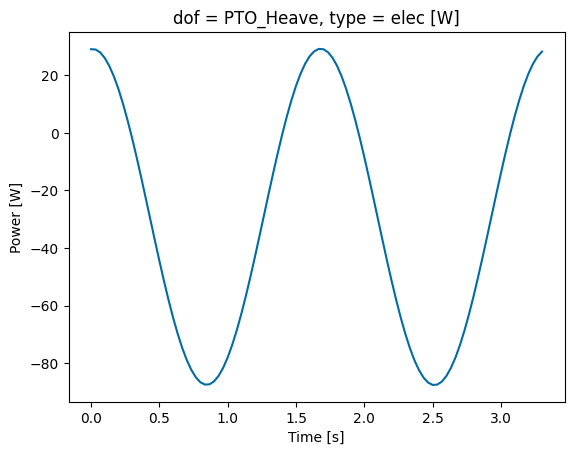

In [14]:
plt.figure()
pto_tdom[0]['power'].sel(type='elec').plot(label='optimal electrical, constrained')

## 2. Frequency Domain

In [15]:
# from numpy.linalg import inv

In [16]:
# Zi = intrinsic_impedance.data
# Zp = pto_impedance.transpose(2,0,1)
# Fe = wot.wave_excitation(bem_data.excitation_force, waves)
# pto_ndof = pto.ndof
# K = kinematics # np.expand_dims(kinematics, axis=-1)

In [17]:
# Zp = pto_impedance.transpose(2,0,1)
# Zp_fu = Zp[:, :pto_ndof, :pto_ndof]
# Zp_vu = Zp[:, pto_ndof:, :pto_ndof]
# Zp_fi = Zp[:, :pto_ndof, pto_ndof:]
# Zp_vi = Zp[:, pto_ndof:, pto_ndof:]

In [18]:
# Zi_p = inv(K @ inv(Zi) @ K.T)
# Fe_p = Zi_p @ K @ inv(Zi) @ Fe

In [19]:
# D = inv(Zi_p-Zp_fu)
# Vth = D @ Zp_vu @ Fe_p
# Zth = Zp_vi + D @ Zp_fi @ Zp_vu

In [20]:
# Ith = inv(np.real(Zth)) @ Vth / 2 # should be positive
# I_opt = -Ith
# V_opt = np.conjugate(Zth) @ Ith

In [21]:
# i_opt = wot.fd_to_td(np.squeeze(I_opt), f1, nfreq, False)
# v_opt = wot.fd_to_td(np.squeeze(V_opt), f1, nfreq, False)
# p_opt = i_opt * v_opt

In [22]:
# fig, ax = plt.subplots()
# ax.plot(wec.time, p_opt)
# pto_tdom[0]['power'].sel(type='elec').plot(ax=ax)
# plt.title("Power")

In [23]:
# np.mean(p_opt)

In [24]:
# fig, ax = plt.subplots()
# ax.plot(wec.time, v_opt)
# pto_tdom[0].trans_eff.plot(ax=ax)
# plt.title("Voltage")

In [25]:
# fig, ax = plt.subplots()
# ax.plot(wec.time, i_opt)
# pto_tdom[0].trans_flo.plot(ax=ax)
# plt.title("Current")

In [26]:
# # impedance dimension names
# tmp_names = [[name+"_flow_port_1", name+"_flow_port_2"] for name in pto_names]
# pto_flows = np.array(tmp_names).flatten(order='F')
# tmp_names = [[name+"_effort_port_1", name+"_effort_port_2"] for name in pto_names]
# pto_efforts = np.array(tmp_names).flatten(order='F')

# # convert to xarray
# Zp = xr.DataArray(
#     np.transpose(pto_impedance, axes=[2,0,1]),
#     dims=['frequency', 'pto_efforts', 'pto_flows'],
#     coords={
#         'frequency': freq,
#         'pto_flows': pto_flows,
#         'pto_efforts': pto_efforts,
#     },
# )


# Zp_fu = Zp.isel(pto_efforts=slice(0, pto.ndof), pto_flows=slice(0, pto.ndof))
# Zp_vu = Zp.isel(pto_efforts=slice(pto.ndof, None), pto_flows=slice(0, pto.ndof))
# Zp_fi = Zp.isel(pto_efforts=slice(0, pto.ndof), pto_flows=slice(pto.ndof, None))
# Zp_vi = Zp.isel(pto_efforts=slice(pto.ndof, None), pto_flows=slice(pto.ndof, None))

# inv(A @ inv(M) @ A.T) @ A @ inv(M)

In [27]:
Zi = intrinsic_impedance.data
Zp = pto_impedance.transpose(2,0,1)
# Fe = wot.wave_excitation(hd.excitation_force, waves)
exc_coeff = hd['Froude_Krylov_force'] + hd['diffraction_force']
Fe = wot.wave_excitation(exc_coeff, waves)

In [28]:
Zp_fu = Zp[0,0,0]
Zp_vu = Zp[0,1,0]
Zp_fi= Zp[0,0,1]
Zp_vi = Zp[0,1,1]

Zp_fu, Zp_vu, Zp_fi, Zp_vi

((-144-542.8672105403163j),
 (-98.46948765988375+0j),
 (-98.46948765988375+0j),
 (0.5+0j))

In [29]:
Zi = Zi[0,0,0]
# Fe = Fe[0,0,0]
Fe = waves.data[0,0,0] * exc_coeff.data[0,0,0]
Zi, Fe

((1011.4482402036944-8932.323306827984j),
 (856.4606723739181+632.2493816552201j))

In [31]:
Vth = Zp_vu * Fe / (Zi - Zp_fu)
Zth = Zp_vi + Zp_fi * Zp_vu / (Zi - Zp_fu)
Ith = Vth / (2*np.real(Zth))
Zth, Ith, Vth

((0.6562159861922648+1.134249992424798j),
 (4.513779138992846-8.281131891675543j),
 (5.924028058296525-10.868422262168163j))

In [32]:
I = -Ith
V = np.conjugate(Zth) * Ith
I, V

((-4.513779138992846+8.281131891675543j),
 (-6.430859756253474-10.553965085293928j))

In [33]:
np.abs(I), np.abs(V)

(9.43140220343363, 12.358888955978355)

In [34]:
np.abs(pto_fdom[0].trans_flo.data[1]), np.abs(pto_fdom[0].trans_eff.data[1])

(array([9.43507341]), array([12.36202153]))

In [35]:
np.abs(I) / np.abs(pto_fdom[0].trans_flo.data[1])

array([0.9996109])

In [36]:
np.abs(V) / np.abs(pto_fdom[0].trans_eff.data[1])

array([0.9997466])

In [37]:
(np.abs(Vth))**2/(8*np.real(Zth))

29.18564811894609

In [51]:
waves.data[0,0,0], np.conjugate(hd.excitation_force.data)[0,0,0]

((0.05412658773652742+0.031249999999999997j),
 (16925.46224713159+1909.019037655435j))

In [54]:
Fe_1 = wot.wave_excitation(np.conjugate(hd.excitation_force), waves)[0,0,0]
Fe_1

(781.377253926147+1107.7078033233709j)

In [66]:
np.conjugate(hd.excitation_force).shape

(10, 1, 1)

In [73]:
np.expand_dims(waves,-1) * np.conjugate(hd.excitation_force).data

array([[[[ 8.56460672e+02+6.32249382e+02j]],

        [[ 8.66243711e+01+4.67133014e+02j]],

        [[-1.80922814e+02+5.84000765e+01j]],

        [[ 1.72341062e+01-6.81145095e+01j]],

        [[ 1.81740395e+00+2.43792745e+01j]],

        [[ 2.52476853e+00-7.50294955e+00j]],

        [[-2.84395853e+00+4.07831058e-01j]],

        [[ 3.47422113e-02+4.34809905e-01j]],

        [[ 2.60435417e-01+1.44175208e-01j]],

        [[ 1.87526960e-01+1.76699666e-01j]]],


       [[[ 0.00000000e+00+0.00000000e+00j]],

        [[ 0.00000000e+00+0.00000000e+00j]],

        [[-0.00000000e+00+0.00000000e+00j]],

        [[ 0.00000000e+00-0.00000000e+00j]],

        [[ 0.00000000e+00+0.00000000e+00j]],

        [[ 0.00000000e+00-0.00000000e+00j]],

        [[-0.00000000e+00+0.00000000e+00j]],

        [[ 0.00000000e+00+0.00000000e+00j]],

        [[ 0.00000000e+00+0.00000000e+00j]],

        [[ 0.00000000e+00+0.00000000e+00j]]],


       [[[ 0.00000000e+00+0.00000000e+00j]],

        [[ 0.00000000e+00+0.00

In [62]:
Fe_2 = waves.data[0,0,0] * np.conjugate(hd.excitation_force.data[0,0,0])
Fe_2

(856.4606723739181+632.2493816552201j)

In [63]:
np.abs(Fe_1), np.abs(Fe_2)

(1355.5688807643285, 1064.5488076770328)

In [61]:
np.abs(wec_fdom[0].force.sel(type = ['Froude_Krylov', 'diffraction']).sum(dim='type').squeeze()[1])


<xarray.DataArray 'force' ()> Size: 8B
array(1064.54880768)
Coordinates:
    omega           float64 8B 1.885
    influenced_dof  <U5 20B 'DOF_0'
    freq            float64 8B 0.3
    period          float64 8B 3.333
    realization     int64 8B 0

In [74]:
(wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)).shape

(10, 1, 1)